
# Kaggle-ready Cloud–Edge Simulation (RL Gatekeeper, Energy, Fairness)

This notebook is prepared to run on **Kaggle** with **GPU (Tesla T4)**. It implements:

- Baseline protocols: Random, Greedy, EdgePreferred, Auction, Nash (replicated).
- **Energy model** for edge & cloud (per-task energy cost).
- **Fairness metric** (Jain's index).
- **RL Gatekeeper (DQN)** that selects which protocol to use each episode/round.
- Training loop with **checkpointing** saved to `/kaggle/working/`.
- Evaluation, plots, and CSV logging.

**How to use on Kaggle:**
1. Upload this notebook to Kaggle (Code → New Notebook → Upload Notebook).  
2. In Settings, select **Accelerator → GPU** (Tesla T4).  
3. Run cells sequentially. The notebook includes a cell to install PyTorch if missing.

> NOTE: Training can be compute-heavy if you use many episodes or large agent counts. Use checkpointing and shorter pilot runs first.


In [1]:


import sys, subprocess, pkgutil
def install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

# Only install if missing
if pkgutil.find_loader('torch') is None:
    print('Installing torch...')
    install('torch')
else:
    import torch
    print('Torch version:', torch.__version__)


Torch version: 2.6.0+cu124


In [2]:

# Imports & Models
import os, random, math, time, json
from dataclasses import dataclass
from typing import List, Dict, Tuple, Callable
import numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

# Check device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device, torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')

@dataclass
class Node:
    name: str
    speed: float
    net_latency: float
    busy_until: float = 0.0
    total_proc_time: float = 0.0
    processed_tasks: int = 0
    energy_consumed: float = 0.0  # Joules (simulated)
    def expected_finish_time(self, arrival_time: float, demand: float) -> float:
        start = max(arrival_time, self.busy_until)
        proc_time = demand / self.speed
        finish = start + proc_time + self.net_latency
        return finish
    def assign_task(self, arrival_time: float, demand: float, power_watt:float=10.0) -> Tuple[float, float]:
        start = max(arrival_time, self.busy_until)
        proc_time = demand / self.speed
        finish = start + proc_time + self.net_latency
        self.total_proc_time += proc_time
        self.busy_until = finish
        self.processed_tasks += 1
        # energy = power * proc_time (approx)
        self.energy_consumed += power_watt * proc_time
        return start, finish

@dataclass
class Task:
    id: int
    arrival: float
    demand: float

def generate_tasks(num_tasks: int, sim_time: float, demand_mean: float=50, demand_std: float=15, seed: int=None) -> List[Task]:
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    arrivals = np.sort(np.random.uniform(0, sim_time, size=num_tasks))
    demands = np.clip(np.random.normal(demand_mean, demand_std, size=num_tasks), 5, None)
    tasks = [Task(i, float(arrivals[i]), float(demands[i])) for i in range(num_tasks)]
    return tasks


Device: cuda Tesla T4


In [3]:

# Protocols (baselines)
def proto_random(task: Task, edge_nodes: List[Node], cloud: Node) -> Node:
    choices = edge_nodes + [cloud]
    return random.choice(choices)

def proto_greedy(task: Task, edge_nodes: List[Node], cloud: Node) -> Node:
    all_nodes = edge_nodes + [cloud]
    best = min(all_nodes, key=lambda n: n.expected_finish_time(task.arrival, task.demand))
    return best

def proto_edge_preferred(task: Task, edge_nodes: List[Node], cloud: Node) -> Node:
    best_edge = min(edge_nodes, key=lambda n: n.expected_finish_time(task.arrival, task.demand))
    if best_edge.expected_finish_time(task.arrival, task.demand) <= cloud.expected_finish_time(task.arrival, task.demand):
        return best_edge
    return cloud

def proto_auction(task: Task, edge_nodes: List[Node], cloud: Node) -> Node:
    all_nodes = edge_nodes + [cloud]
    scores = {n.name: -n.expected_finish_time(task.arrival, task.demand) for n in all_nodes}
    best_name = max(scores, key=scores.get)
    best_node = next(n for n in all_nodes if n.name == best_name)
    return best_node

def proto_nash(task: Task, edge_nodes: List[Node], cloud: Node) -> Node:
    return proto_greedy(task, edge_nodes, cloud)


In [4]:

# Energy model parameters (tunable)
EDGE_POWER_W = 5.0    # watts per processing CPU unit on edge (example)
CLOUD_POWER_W = 20.0  # watts per processing CPU unit on cloud (higher)
TRANSFER_ENERGY_PER_BYTE = 1e-6  # Joules per byte (very small, used if modeling transfer)
# For simplicity we use proc_time*power as energy

def compute_jain_index(values: List[float]) -> float:
    # values: utilization or utilities per node
    arr = np.array(values, dtype=float)
    if np.all(arr == 0):
        return 1.0
    return (arr.sum()**2) / (len(arr) * (arr**2).sum())

def compute_energy(nodes: List[Node]) -> float:
    return sum(n.energy_consumed for n in nodes)


In [5]:

def run_simulation_with_protocol(protocol_fn: Callable, edge_count:int=3, num_tasks:int=300, sim_time:float=300.0, seed:int=42, node_params:Dict=None, energy_params:Dict=None):
    random.seed(seed); np.random.seed(seed)
    if node_params is None:
        node_params = {'edge_speed':10.0, 'cloud_speed':40.0, 'edge_net_latency':0.02, 'cloud_net_latency':0.12}
    edges = [Node(f'edge{i+1}', speed=node_params['edge_speed'], net_latency=node_params['edge_net_latency']) for i in range(edge_count)]
    cloud = Node('cloud', speed=node_params['cloud_speed'], net_latency=node_params['cloud_net_latency'])
    tasks = generate_tasks(num_tasks=num_tasks, sim_time=sim_time, demand_mean=50, demand_std=20, seed=seed)
    records = []
    for t in tasks:
        chosen = protocol_fn(t, edges, cloud)
        # choose power model per node type
        power = EDGE_POWER_W if chosen.name.startswith('edge') else CLOUD_POWER_W
        start, finish = chosen.assign_task(t.arrival, t.demand, power_watt=power)
        latency = finish - t.arrival
        records.append({'task_id':t.id, 'arrival':t.arrival, 'demand':t.demand, 'node':chosen.name, 'start':start, 'finish':finish, 'latency':latency})
    df = pd.DataFrame(records)
    total_time = sim_time
    node_utils = {n.name:{'processed_tasks':n.processed_tasks, 'total_proc_time':n.total_proc_time, 'utilization':n.total_proc_time/max(total_time,1e-9), 'energy':n.energy_consumed} for n in edges+[cloud]}
    avg_latency = df['latency'].mean()
    p95 = df['latency'].quantile(0.95)
    jain = compute_jain_index([v['utilization'] for v in node_utils.values()])
    energy_total = compute_energy(list(edges)+[cloud])
    summary = {'avg_latency':avg_latency, 'p95_latency':p95, 'jain':jain, 'energy':energy_total}
    return df, summary, node_utils


In [6]:

# Gatekeeper DQN: chooses protocol index each episode based on environment summary state
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class GatekeeperNet(nn.Module):
    def __init__(self, s_dim:int, a_dim:int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, a_dim)
        )
    def forward(self, x):
        return self.net(x)

class Gatekeeper:
    def __init__(self, state_dim:int, action_dim:int, device=device, lr=1e-4):
        self.device = device
        self.net = GatekeeperNet(state_dim, action_dim).to(self.device)
        self.opt = optim.Adam(self.net.parameters(), lr=lr)
        self.replay = []
        self.max_replay = 50000

    def select(self, state:np.ndarray, eps:float=0.1):
        if random.random() < eps:
            return random.randrange(self.net.net[-1].out_features if hasattr(self.net, 'net') else 3)
        s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q = self.net(s)
        return int(q.argmax().item())

    def store(self, s,a,r,s2,d):
        if len(self.replay) > self.max_replay:
            self.replay.pop(0)
        self.replay.append((s,a,r,s2,d))

    def train_step(self, batch_size=64, gamma=0.99):
        if len(self.replay) < batch_size:
            return 0.0
        batch = random.sample(self.replay, batch_size)
        s = torch.tensor(np.stack([b[0] for b in batch]), dtype=torch.float32).to(self.device)
        a = torch.tensor([b[1] for b in batch], dtype=torch.long).to(self.device)
        r = torch.tensor([b[2] for b in batch], dtype=torch.float32).to(self.device)
        s2 = torch.tensor(np.stack([b[3] for b in batch]), dtype=torch.float32).to(self.device)
        d = torch.tensor([b[4] for b in batch], dtype=torch.float32).to(self.device)
        q = self.net(s)
        q_a = q.gather(1, a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            q2 = self.net(s2).max(1)[0]
            target = r + gamma * q2 * (1 - d)
        loss = F.mse_loss(q_a, target)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        return loss.item()


In [7]:

# Training loop - high level. Start with small runs to validate.
protocol_list = [proto_auction, proto_nash, proto_greedy]  # actions: 0,1,2
protocol_names = ['Auction','Nash','Greedy']

def env_summary_state(edges, cloud, recent_latencies):
    # state vector: [avg_util, avg_latency, jain, last_protocol_onehot(3)]
    utils = [n.total_proc_time for n in edges+[cloud]]
    total_time = max(1.0, sum(utils))
    avg_util = np.mean([u/total_time for u in utils])
    avg_lat = np.mean(recent_latencies) if len(recent_latencies)>0 else 0.0
    jain = compute_jain_index([n.total_proc_time/total_time for n in edges+[cloud]])
    return np.array([avg_util, avg_lat, jain], dtype=np.float32)

# Hyperparams (small for Kaggle pilot)
EPISODES = 200
TASKS_PER_EP = 300
EDGES = 3
SIM_TIME = 300.0
SAVE_EVERY = 50
alpha_energy = 0.1  # weight for energy in reward (tweak)
beta_fair = 0.5     # weight for fairness

gk = Gatekeeper(state_dim=3, action_dim=len(protocol_list), device=device, lr=1e-4)

log_rows = []
for ep in range(1, EPISODES+1):
    # reset nodes per episode inside run function via protocol choice per-task (we apply one protocol for the whole episode here)
    # select protocol for episode
    # form a quick state (we use zeros initially)
    state = np.zeros(3, dtype=np.float32)
    action = gk.select(state, eps=max(0.05, 0.2*(1-ep/EPISODES)))
    proto = protocol_list[action]
    # run environment with chosen protocol
    df, summary, node_utils = run_simulation_with_protocol(proto, edge_count=EDGES, num_tasks=TASKS_PER_EP, sim_time=SIM_TIME, seed=ep)
    # compute reward: negative avg_latency minus energy term plus fairness bonus
    reward = -summary['avg_latency'] - alpha_energy*summary['energy'] + beta_fair*summary['jain']
    # next state (simple): use summary stats
    next_state = np.array([np.mean([v['total_proc_time'] for v in node_utils.values()])/ (SIM_TIME+1e-9), summary['avg_latency'], summary['jain']], dtype=np.float32)
    done = False
    gk.store(state, action, reward, next_state, done)
    loss = gk.train_step(batch_size=32)
    log_rows.append({'episode':ep, 'protocol':protocol_names[action], 'avg_latency':summary['avg_latency'], 'p95':summary['p95_latency'], 'jain':summary['jain'], 'energy':summary['energy'], 'reward':reward, 'loss':loss})
    if ep % 10 == 0:
        print(f"Ep {ep}/{EPISODES} | proto={protocol_names[action]} | avg_lat={summary['avg_latency']:.3f} | jain={summary['jain']:.3f} | energy={summary['energy']:.1f}")
    if ep % SAVE_EVERY == 0:
        ckpt_path = f"/kaggle/working/gk_checkpoint_ep{ep}.pt"
        torch.save({'episode':ep, 'net_state': gk.net.state_dict(), 'opt_state': gk.opt.state_dict()}, ckpt_path)
        print('Saved checkpoint', ckpt_path)

# save log
log_df = pd.DataFrame(log_rows)
log_df.to_csv('/kaggle/working/training_log.csv', index=False)
print('Training finished. Logs & checkpoints in /kaggle/working/')

Ep 10/200 | proto=Auction | avg_lat=4.499 | jain=0.917 | energy=7542.2
Ep 20/200 | proto=Auction | avg_lat=4.270 | jain=0.899 | energy=7556.1
Ep 30/200 | proto=Auction | avg_lat=4.157 | jain=0.877 | energy=7398.4
Ep 40/200 | proto=Nash | avg_lat=4.504 | jain=0.909 | energy=7784.8
Ep 50/200 | proto=Nash | avg_lat=3.839 | jain=0.868 | energy=7261.4
Saved checkpoint /kaggle/working/gk_checkpoint_ep50.pt
Ep 60/200 | proto=Greedy | avg_lat=4.811 | jain=0.924 | energy=7620.5
Ep 70/200 | proto=Nash | avg_lat=4.108 | jain=0.877 | energy=7408.3
Ep 80/200 | proto=Nash | avg_lat=4.145 | jain=0.891 | energy=7569.3
Ep 90/200 | proto=Nash | avg_lat=4.176 | jain=0.903 | energy=7452.8
Ep 100/200 | proto=Greedy | avg_lat=4.526 | jain=0.896 | energy=7726.6
Saved checkpoint /kaggle/working/gk_checkpoint_ep100.pt
Ep 110/200 | proto=Greedy | avg_lat=4.086 | jain=0.897 | energy=7467.6
Ep 120/200 | proto=Greedy | avg_lat=4.168 | jain=0.893 | energy=7675.2
Ep 130/200 | proto=Greedy | avg_lat=4.209 | jain=0.90

Loaded /kaggle/working/gk_checkpoint_ep50.pt


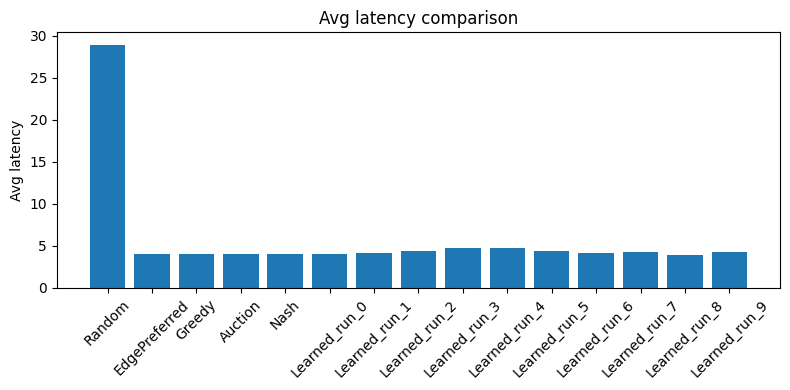

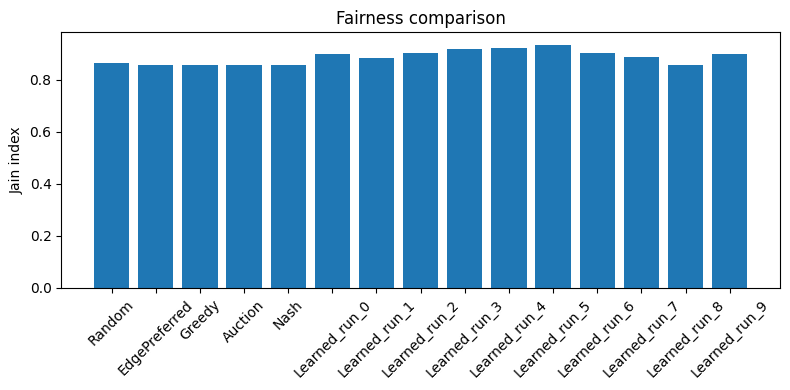

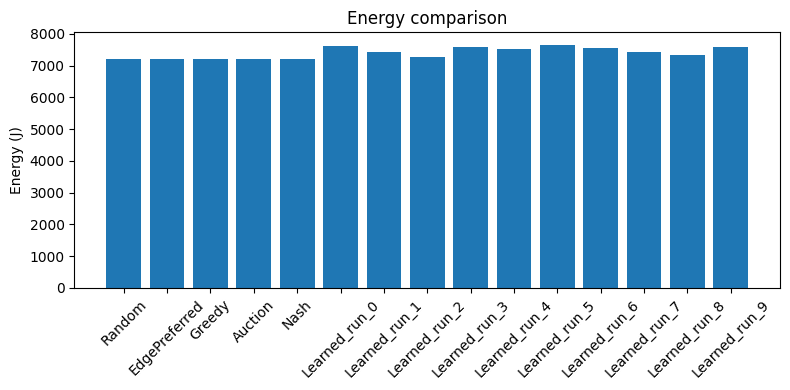

Evaluation saved to /kaggle/working/


In [8]:

# After training: evaluate gatekeeper policy vs baselines
# Load last checkpoint if exists
import glob
ckpts = sorted(glob.glob('/kaggle/working/gk_checkpoint_ep*.pt'))
if len(ckpts)>0:
    ck = torch.load(ckpts[-1], map_location=device)
    gk.net.load_state_dict(ck['net_state'])
    print('Loaded', ckpts[-1])

# Evaluate baseline strategies + learned policy (use policy to pick per-episode protocol)
strategies = {'Random':proto_random, 'EdgePreferred':proto_edge_preferred, 'Greedy':proto_greedy, 'Auction':proto_auction, 'Nash':proto_nash}

eval_results = {}
for name, fn in strategies.items():
    df, summ, node_utils = run_simulation_with_protocol(fn, edge_count=3, num_tasks=300, sim_time=300.0, seed=999)
    eval_results[name] = summ

# Learned policy evaluation: choose protocol by gk.net state (we use zero-state as example)
def eval_learned(gk, episodes=5):
    rows = []
    for ep in range(episodes):
        s = np.zeros(3, dtype=np.float32)
        a = gk.select(s, eps=0.0)
        proto = protocol_list[a]
        df, summ, nu = run_simulation_with_protocol(proto, edge_count=3, num_tasks=300, sim_time=300.0, seed=1000+ep)
        rows.append((protocol_names[a], summ))
    return rows

learned_rows = eval_learned(gk, episodes=10)
for i,(p,summ) in enumerate(learned_rows):
    eval_results[f'Learned_run_{i}'] = summ

# Plot comparisons
names = list(eval_results.keys())
avg_lat = [eval_results[n]['avg_latency'] for n in names]
p95 = [eval_results[n]['p95_latency'] for n in names]
jains = [eval_results[n]['jain'] for n in names]
ener = [eval_results[n]['energy'] for n in names]

plt.figure(); plt.bar(names, avg_lat); plt.ylabel('Avg latency'); plt.title('Avg latency comparison'); plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('/kaggle/working/eval_avg_latency.png'); plt.show()
plt.figure(); plt.bar(names, jains); plt.ylabel('Jain index'); plt.title('Fairness comparison'); plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('/kaggle/working/eval_jain.png'); plt.show()
plt.figure(); plt.bar(names, ener); plt.ylabel('Energy (J)'); plt.title('Energy comparison'); plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('/kaggle/working/eval_energy.png'); plt.show()

pd.DataFrame([{**{'strategy':n}, **eval_results[n]} for n in names]).to_csv('/kaggle/working/eval_summary.csv', index=False)
print('Evaluation saved to /kaggle/working/')


## Notes & Tips

- Start with `EPISODES = 200` and `TASKS_PER_EP = 300` for a pilot run. Increase after you confirm correctness.
- Use checkpointing: Kaggle sessions are limited; saving every `SAVE_EVERY` episodes allows resuming.
- Tune `alpha_energy` and `beta_fair` to reflect priorities.
- For scaling to 20 agents, increase `edge_count` and consider longer training.
- If you want I can also produce a ready-to-run Kaggle Notebook link or split this into smaller runnable cells.
